In [1]:
import sys,os, pprint
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Temporary plotting function that needs to be updated in modelingsdk

import csv
import matplotlib.pyplot as plt

def plot_rates_popnet(cell_models_file, rates_file, model_keys=None, save_as=None, show_plot=True):
    """Initial method for plotting popnet output

    :param cell_models_file:
    :param rates_file:
    :param model_keys:
    :param save_as:
    :param show_plot:
    :return:
    """

    pops_df = pd.read_csv(cell_models_file, sep=' ')
    lookup_col = model_keys if model_keys is not None else 'node_type_id'
    pop_keys = {str(r['node_type_id']): r[lookup_col] for _, r in pops_df.iterrows()}

    # organize the rates file by population
    rates = {pop_name: ([], []) for pop_name in pop_keys.keys()}
    with open(rates_file, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            if row[0] in rates:
                rates[row[0]][0].append(row[1])
                rates[row[0]][1].append(row[2])

    # plot the rates
    plt.figure()
    for pop_name, r in rates.iteritems():
        label = pop_keys[pop_name]
        times = r[0]
        rates = r[1]
        if len(times) == 0:
            continue

        plt.plot(times, rates, label=label)

    plt.legend(fontsize='x-small')
    plt.xlabel('time (s)')
    plt.ylabel('firing rates (Hz)')

    if save_as is not None:
        plt.savefig(save_as)

    if show_plot:
        plt.show()

# Modeling a coupled excitatory-inhibitory (E-I) network with DiPDE/popnet 

In this tutorial, we will demonstrate simulation of an E-I network consisting of homogenous excitatory (E) and inhibitory (I) populations using the DiPDE simulator. In this example, only the excitatory (E) population is being driven by excitatory input from the external (Ext) population. 

(-0.5, 1220.5, 982.5, -0.5)

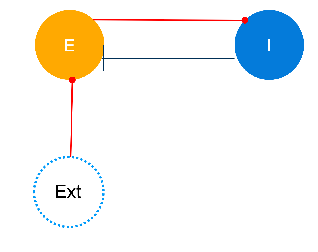

In [3]:
#The figure below shows the schematic of the network that we will simulate. 
img=mpimg.imread('schematics_png/DiPDE_ei_net.png')
plt.figure(figsize = (5, 4))
plt.imshow(img)
plt.axis('off')

# Building the network

We will build the network step-by-step as follows:

1) Create/parameterize the nodes (populations) in the internal network, namely the E and I populations

2) Create/parameterize the external population. 

3) Create/parameterize the edge (connection) from the external population to the E population.

4) Connect the E population to the I population

5) Run simulation and observe output

6) Exercise: Connect I to E and explore how the outputs change

In [4]:
#Create a folder called network. 
#Within this folder, we create a folder'recurrent_network' where the nodes and edges in our example will be saved
directory_name = 'network/recurrent_network/'

if not os.path.exists(directory_name):
    os.makedirs(directory_name)

We will explore the directory structure for saving nodes and edges later. For now, just note that we will be creating
node and edge parameter files and storing them in the 'network' folder  

## 1) Building E and I nodes
Let's start with creating a network object and add a single Excitatory population

In [5]:
#Import appropriate DiPDE modules

from modelingsdk.builder.networks import NxNetwork
import modelingsdk.simulator.utils.config as config
from modelingsdk.simulator.popnet.graph import Graph
from modelingsdk.simulator.popnet.network import Network

#Create network object
net = NxNetwork('V1')
#net.clear()

In [6]:
# Add 'E' node to 'net'
net.add_nodes(node_type_id='0', pop_name='excitatory', params_file='excitatory_pop.json')

The default parameters for the excitatory population are stored in the json file. Let's see what they are. We will see below how the default parameters can be changed

In [ ]:
import pprint
import json

#Load the json file
with open('components/pop_models/excitatory_pop.json') as exc_data:
    exc_prs = json.load(exc_data)

#Print the parameters    
pprint.pprint(exc_prs)

### What do these parameters correspond to?

{u'approx_order': None,      # 
 u'dv': 0.0001,              #  grid-size for the membrane potential (in volts) 
 u'record': True,            # 
 u'tau_m': 0.0429,           #  membrane time-constant for each neuron in the population (in seconds)
 u'update_method': u'gmres', # 
 u'v_max': 0.02,             #  threshold membrane potential (in volts)
 u'v_min': -0.05             #  resting membrane potential   (in volts)
}         

### Exercise
Follow the steps above to add an 'I' node (inhibitory population) to the network. You can set the node_type_id to 1 and replace 'excitatory' with 'inhibitory' for the other two fields.   

In [7]:
# Add 'I' node to 'net'
net.add_nodes(node_type_id='1', pop_name='inhibitory', params_file='inhibitory_pop.json')

Now that we have created the nodes and added them to the network, the next step is to save the nodes' information to a .csv file.

In [8]:
#Provide filename that will contain information about the types of nodes:
node_models_file = directory_name + 'node_types.csv' #filename to save to

#Save node information. The columns to be saved in this file are set by the user. Note that node_type_id is needed here
net.save_types(filename=node_models_file,
                   columns=['node_type_id', 'pop_name', 'params_file'])

In [9]:
# Let's display what is contained in the node_types file.
node_types_DF = pd.DataFrame.from_csv(node_models_file, sep = ' ')
node_types_DF

,pop_name,params_file
node_type_id,,
0,excitatory,excitatory_pop.json
1,inhibitory,inhibitory_pop.json


# 2) Building the Ext input node (as part of a separate 'input network')

Along the same lines as for the E-I network, we will now create an external input network with a single node. 

In [10]:
#Create input network object
inputNetwork = NxNetwork("inputNetwork")
#inputNetwork.clear()

#Add 'Ext' node to inputNetwork 
inputNetwork.add_nodes(node_type_id ='filter_001', ei='e', pop_name='input_filter', level_of_detail='filter')

#Create a separate directory for external inputs and provide filename to save to:
input_directory_name = 'network/source_input/'

if not os.path.exists(input_directory_name):
    os.makedirs(input_directory_name)

input_models_file = input_directory_name + 'input_node_types.csv'

#Save node information to file. 
inputNetwork.save_types(filename=input_models_file, columns=['node_type_id','level_of_detail','ei', 'pop_name'])

### Exercise
Display what is contained in the input_node_types file that you just saved

In [11]:
input_node_types_DF = pd.DataFrame.from_csv(input_models_file, sep = ' ')
input_node_types_DF

,level_of_detail,ei,pop_name
node_type_id,,,
filter_001,filter,e,input_filter


# 3) Building the edge from Ext to E
Now we will create the edge connecting Ext population to E population

In [12]:
inputNetwork.connect(source = inputNetwork.nodes(),#(pop_name = 'ext_excitatory'),
            target = net.nodes(pop_name = 'excitatory'),
            edge_params={'weight': 0.0025, 
                         'delay': 0.002, 
                         'nsyns': 10,
                         'params_file': 'InpToExc.json'} 
                         )

Let us unpack this a bit. To establish a connection, we provide the source (node named'ext_excitatory' in inputNetwork) and the target (node named 'excitatory' in net). We also provide the parameters for the edge contained in edge_params. For DiPDE/popnet, each edge is specified by the following:

1) 'weight' : synaptic weight in volts

2) 'delay' : synaptic delay in seconds

3) 'nsyns' : number of synapses from source onto target. 

4) 'params_file': optional filename to save parameters to.

# Build network..

In [13]:
inputNetwork.build()

## Save connection to csv file

In [14]:
#Specify filename to save to
input_edge_types_file   = input_directory_name + 'input_edge_types.csv'

#Save edge parameters
inputNetwork.save_edge_types(filename=input_edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])

input_edge_types_DF = pd.DataFrame.from_csv(input_edge_types_file, sep = ' ')
input_edge_types_DF

,target_query,source_query,weight,delay,nsyns,params_file
edge_type_id,,,,,,
0,pop_name=='excitatory',*,0.0025,0.002,10,InpToExc.json


# 4) Build the edge from E to I and then build net
Now let's create the edge connecting E population to I population. Note now that both populations are nodes in net. Remember to save edge after specifying filename.  

In [15]:
#connect E to I in net
net.connect(source = net.nodes(pop_name = 'excitatory'),
            target = net.nodes(pop_name = 'inhibitory'),
            edge_params={'weight': 0.005, 
                         'delay': 0.002, 
                         'nsyns': 20,
                         'params_file': 'ExcToInh.json'} 
                         )
#build net
net.build()

#Specify filename to save to
edge_types_file   = directory_name + 'edge_types.csv'

#Save edge parameters
net.save_edge_types(filename=edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])

edge_types_DF = pd.DataFrame.from_csv(edge_types_file, sep = ' ')
edge_types_DF

,target_query,source_query,weight,delay,nsyns,params_file
edge_type_id,,,,,,
1,pop_name=='inhibitory',pop_name=='excitatory',0.005,0.002,20,ExcToInh.json


# 5) Run simulation

## Config file
At this point, we have created and saved a bunch of files (nodes, edges etc.). All of this needs to be integrated together, which is what is done in a config file. A default config file ('config.json') has already been created for us that contains:

1) runtime settings for the simulation in 'run'. We will see below how to change the default settings.

2) filenames for the different nodes and edges (we used these names keeping the directory structure specified here)

3) filenames for where the output should be stored.

Feel free to also look at the config file directly as it will look better than the print function below.

In [16]:
configure = config.from_json('config.json')
#pprint.pprint(configure)

In [17]:
#Create a graph structure using the nodes and edges specified in the config file.
graph = Graph(configure)

### Let's see some simple examples of changing default parameters in the config file
Change duration of simulation from 3 seconds to 0.5 seconds

In [18]:
configure['run']['duration'] = 0.5

Change firing rate of input excitatory population (Ext) after checking the default value 

In [19]:
input_pop = graph.get_population('input_filter',network='filter')
print input_pop.firing_rate
input_pop.firing_rate = 25.0  #(Firing rate in Hz)
print input_pop.firing_rate

exc_pop = graph.get_population('excitatory')
print exc_pop.tau_m
exc_pop.tau_m = 0.02
print exc_pop.tau_m

-1
25.0
0.0429
0.02


### Run the simulation

In [20]:
full_net = Network(configure,graph)
full_net.build()
full_net.run()

#print ff_net.connections

External Population input_filter firing at a rate of 25.0 Hz.
running simulation...
done simulation.


### Analyze firing rate outputs of the E and I populations

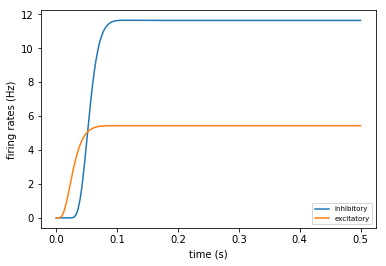

In [21]:
cells_file = configure['internal']['node_types']
rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')

## Exercise (time permitting): Add an I to E connection, save the edge, build the network and re-run the simulation to see how the outputs change 

In [22]:
#connect I to E in net
net.connect(source = net.nodes(pop_name = 'inhibitory'),
            target = net.nodes(pop_name = 'excitatory'),
            edge_params={'weight': -0.001, 
                         'delay': 0.002, 
                         'nsyns': 10,
                         'params_file': 'InhToExc.json'} 
                         )
#build net
net.build()

#Specify filename to save to
edge_types_file   = directory_name + 'edge_types.csv'

#Save edge parameters
net.save_edge_types(filename=edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])

edge_types_DF = pd.DataFrame.from_csv(edge_types_file, sep = ' ')
edge_types_DF

,target_query,source_query,weight,delay,nsyns,params_file
edge_type_id,,,,,,
1,pop_name=='inhibitory',pop_name=='excitatory',0.005,0.002,20,ExcToInh.json
2,pop_name=='excitatory',pop_name=='inhibitory',-0.001,0.002,10,InhToExc.json


External Population input_filter firing at a rate of 25.0 Hz.
running simulation...
done simulation.


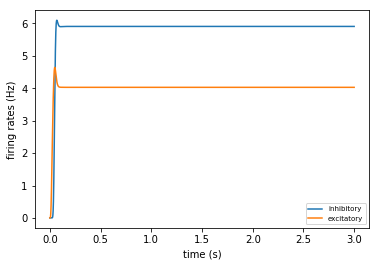

In [24]:
configure = config.from_json('config.json')
graph = Graph(configure)

#input_pop = graph.get_population('input_filter',network='filter')
graph.get_population('input_filter',network='filter').firing_rate = 25.0
graph.get_population('excitatory').tau_m = 0.02
#input_pop.firing_rate

ei_net = Network(configure,graph)
ei_net.build()
ei_net.run()

rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')